<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_0509_Opinion_Review_Mercari_Price_Suggestion_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 실습 필사 - 0509(월) 10주차 과제
 
## <파이썬 머신러닝 완벽 가이드>
## Chapter 8 텍스트 분석

### 07 문서 군집화 소개와 실습(Opinion Review 데이터 세트)
#### 문서 군집화 개념
* 문서 군집화(Document Clustering) : 비슷한 텍스트 구성의 문서를 군집화(Clustering)하는 것
* 텍스트 분류 기반의 문서 분류와의 비교
  - 유사한 점 : 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류
  - 다른 점 : 학습 데이터 세트가 필요 없는 비지도학습 기반으로 동작
  
   <-> 텍스트 분류 : 사전에 결정 카테고리 값을 가진 학습 데이터 세트 필요

#### Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기
* Opinion Review 데이터 세트
  - 51개의 텍스트 파일로 구성 : 각 파일은 Tripadvisor(호텔), Edmunds.com(자동차), Amazon.com(전자제품) 사이트에서 가져온 리뷰 문서, 100개 정도의 문장으로 이루어짐

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


여러 개의 파일을 한 개의 DataFrame으로 로딩

In [5]:
import pandas as pd
import glob, os

path = r'/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0509(월) 10주차 과제/OpinosisDataset1.0/OpinosisDataset1.0/topics'                     
# path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합, 
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text list로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0, encoding='latin1')
    
    # 절대 경로로 주어진 파일명을 가공. 리눅스에서 수행할 때는 다음 \\를 /로 변경
    # 맨 마지막 .data 확장자도 제거
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]

    # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,navigation_amazon_kindle,...
1,mileage_honda_accord_2008,...
2,location_holiday_inn_london,...
3,location_bestwestern_hotel_sfo,...
4,keyboard_netbook_1005ha,...


개별 문서에 TF-IDF 피처 벡터화 적용

In [6]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [8]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1, 2), min_df=0.05, max_df=0.85 )

# opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


피처 벡터화 행렬 데이터에 K-평균 군집화 수행

> 5개 중심 기반 군집화

In [10]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [11]:
# cluster_label에 각 데이터별로 할당된 군집 레이블 저장
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,navigation_amazon_kindle,...,1
1,mileage_honda_accord_2008,...,0
2,location_holiday_inn_london,...,3
3,location_bestwestern_hotel_sfo,...,3
4,keyboard_netbook_1005ha,...,1


군집이 각 주제별로 유사한 형태로 구성됐는지 확인

In [12]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
17,comfort_honda_accord_2008,...,0
16,comfort_toyota_camry_2007,...,0
48,gas_mileage_toyota_camry_2007,...,0
49,interior_honda_accord_2008,...,0
6,interior_toyota_camry_2007,...,0
1,mileage_honda_accord_2008,...,0
43,performance_honda_accord_2008,...,0
40,quality_toyota_camry_2007,...,0
37,seats_honda_accord_2008,...,0
21,transmission_toyota_camry_2007,...,0


* Cluster #0 : 토요타와 혼다 등 자동차에 대한 리뷰

In [13]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
11,buttons_amazon_kindle,...,1
8,eyesight-issues_amazon_kindle,...,1
45,fonts_amazon_kindle,...,1
4,keyboard_netbook_1005ha,...,1
0,navigation_amazon_kindle,...,1
44,performance_netbook_1005ha,...,1
38,screen_ipod_nano_8gb,...,1
39,screen_netbook_1005ha,...,1
30,size_asus_netbook_1005ha,...,1
26,speed_windows7,...,1


* Cluster #1 : 킨들, 아이팟, 넷북 등 포터블 전자기기에 대한 리뷰

In [14]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
13,battery-life_amazon_kindle,...,2
12,battery-life_ipod_nano_8gb,...,2
15,battery-life_netbook_1005ha,...,2
42,price_amazon_kindle,...,2


* Cluster #2 : 킨들, 아이팟, 넷북 등 포터블 전자기기에 대한 리뷰

In [15]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
14,bathroom_bestwestern_hotel_sfo,...,3
5,food_holiday_inn_london,...,3
47,food_swissotel_chicago,...,3
46,free_bestwestern_hotel_sfo,...,3
3,location_bestwestern_hotel_sfo,...,3
2,location_holiday_inn_london,...,3
50,parking_bestwestern_hotel_sfo,...,3
41,price_holiday_inn_london,...,3
28,room_holiday_inn_london,...,3
34,rooms_bestwestern_hotel_sfo,...,3


* Cluster #3 : 호텔에 대한 리뷰

In [16]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
18,accuracy_garmin_nuvi_255W_gps,...,4
10,directions_garmin_nuvi_255W_gps,...,4
9,display_garmin_nuvi_255W_gps,...,4
7,features_windows7,...,4
33,satellite_garmin_nuvi_255W_gps,...,4
32,screen_garmin_nuvi_255W_gps,...,4
29,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,4
25,speed_garmin_nuvi_255W_gps,...,4
20,updates_garmin_nuvi_255W_gps,...,4
19,voice_garmin_nuvi_255W_gps,...,4


* Cluster #4 : 주로 차량용 네비게이션에 대한 리뷰

=> 군집 개수가 약간 많게 설정돼 있어서 세분화되어 군집화된 경향 有

> 3개 중심 기반 군집화

In [17]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
50,parking_bestwestern_hotel_sfo,...,0
23,staff_swissotel_chicago,...,0
27,service_swissotel_hotel_chicago,...,0
28,room_holiday_inn_london,...,0
31,service_holiday_inn_london,...,0
34,rooms_bestwestern_hotel_sfo,...,0
14,bathroom_bestwestern_hotel_sfo,...,0
35,rooms_swissotel_chicago,...,0
24,staff_bestwestern_hotel_sfo,...,0
36,service_bestwestern_hotel_sfo,...,0


* Cluster #0 : 호텔 리뷰
* Cluster #1 : 포터블 전자기기 리뷰
* Cluster #2 : 자동차 리뷰

#### 군집별 핵심 단어 추출하기

* `Kmeans.cluster_centers_` : 각 군집을 구성하는 단어 피처가 군집의 중심을 기준으로 얼마나 가깝게 위치해 있는지 배열 값(넘파이 ndarray)으로 제공
  - 행 : 개별 군집
  - 열 : 개별 피처
  - 값 : 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값

군집 3개로 생성한 KMeans 객체의 cluster_centers_ 속성값 확인

In [18]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


* cluster_centers_ : (3, 4611) 배열
  - 군집 3개
  - word 피처 4611개
  - 각 행 배열 값은 각 군집 내 4611개 피처 위치가 개별 중심과 얼마나 가까운가를 상대 값으로 표현
    - 0에서 1까지의 값 -> 1에 가까울수록 중심과 가까운 값

각 군집별 핵심 단어 확인

In [19]:
# 군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명을 반환함
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:, ::-1] 로 구한 인덱스를 이용해 top n 피처 단어를 구함
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

* cluster_details : 딕셔너리를 원소로 가지는 리스트 - 개별 군집번호, 핵심 단어, 핵심단어 중심 위치 상댓값, 파일명 속성 값 정보 포함

In [20]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [21]:
feature_names = tfidf_vect.get_feature_names() # 피처명 리스트 추출

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                      feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['location_holiday_inn_london', 'location_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'bathroom_bestwestern_hotel_sfo', 'staff_swissotel_chicago', 'staff_bestwestern_hotel_sfo', 'service_swissotel_hotel_chicago']
####### Cluster 1
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['navigation_amazon_kindle', 'keyboard_netbook_1005ha', 'features_windows7', 'eyesight-issues_amazon_kindle', 'display_garmin_nuvi_255W_gps', 'directions_garmin_nuvi_255W_gps', 'buttons_amazon_kindle']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['mileage_honda_accord_2008', 'interior_toyota_camry_2007', 'comfort_toyota_camry_2007', 'comfort_honda_accord_2008'

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


* Cluster #0(호텔 리뷰 군집) : 방과 서비스 등
* Cluster #1(포터블 전자제품 리뷰 군집) : 화면과 배터리 수명 등
* Cluster #2(자동차 리뷰 군집) : 실내 인테리어, 좌석, 연료 효율 등

### 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge
* 일본의 대형 온라인 쇼핑몰 Mercari사의 제품에 대해 가격 예측하는 과제
  - item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀 수행
* 데이터 세트의 속성
  - train_id : 데이터 id
  - name : 제품명
  - item_condition_id : 판매자가 제공하는 제품 상태
  - category_name : 카테고리 명
  - brand_name : 브랜드 이름
  - price : 제품 가격, 예측을 위한 타깃 속성
  - shipping : 배송비 무료 여부. 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
  - item_description : 제품에 대한 설명

#### 데이터 전처리

필요한 라이브러리와 데이터 로딩

In [2]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0509(월) 10주차 과제/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


피처 타입과 Null 여부 확인

In [3]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


* brand_name : 매우 많은 Null 값 가짐
* category_name : 약 6300건의 Null 값
* item_description : 4건의 Null 값

price 칼럼의 데이터 분포도 확인

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


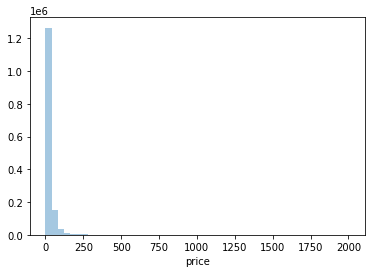

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False)

* 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포

  -> 로그 값으로 변환

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


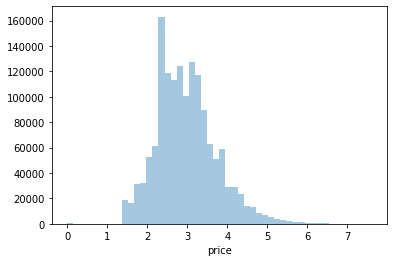

In [5]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

* 비교적 정규 분포에 가까운 데이터

price 칼럼을 로그 변환된 값으로 변경

In [6]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

shipping, item_condition_id 값 유형 확인

In [7]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


* shipping : 값이 비교적 균일
* item_condition_id : 1, 2, 3 값이 주를 이룸

item_description 칼럼 값 확인

In [8]:
boolean_cond = mercari_df['item_description']=='No description yet' # description에 대한 별도 설명이 없는 경우
mercari_df[boolean_cond]['item_description'].count()

82489

* 'No description yet' 역시 의미있는 속성값으로 사용 불가
  
  -> 적절한 값으로 변경 필요

category_name 칼럼을 대, 중, 소분류로 분리

* category_name : '/'로 분리된 카테고리를 하나의 문자열로 표현
  
  -> '/'를 기준으로 단어 토큰화해 각각 별도의 피처로 저장 후 알고리즘 학습

In [9]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try: # category_name이 Null이 아닌 경우
        return category_name.split('/')
    except: # category_name이 Null인 경우
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat( )을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성 
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수 : 114
소분류 갯수 : 871


brand_name, category_name, item_description 칼럼의 Null 값 변경

In [10]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null 값 건수 확인. 모두 0이 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화

* 피처 인코딩 
  - 선형 회귀 모델과 회귀 트리 모델 모두 적용할 예정
    - 선형 회귀의 경우 원-핫 인코딩이 훨씬 선호 
    
      -> 인코딩할 피처는 모두 원-핫 인코딩 적용
* 피처 벡터화
  - 비교적 짧은 텍스트는 Count 기반 벡터화
  - 긴 텍스트는 TF-IDF 기반 벡터화

> brand_name

In [11]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


* 대부분 명료한 문자열
  
  -> 별도의 피처 벡터화 없이 원-핫 인코딩 변환 적용

> name

In [12]:
print('name 의 종류 개수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

name 의 종류 개수 : 1225273
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


* 개별적으로 거의 고유한 상품명
* 유형이 매우 많고, 적은 단어 위주의 텍스트 형태
  
  -> Count 기반 피처 벡터화 변환 적용 


> category_name

* cat_dae, cat_jung, cat_so 모두 원-핫 인코딩 변환 적용

> shipping

* 0, 1 두 가지 유형
  
  -> 원-핫 인코딩 적용

> item_condition_id

* 1, 2, 3, 4, 5  다섯 가지 유형

  -> 원-핫 인코딩 적용

> item_description

In [13]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

* 데이터 세트에서 가장 긴 텍스트
  
  -> TF-IDF 벡터화 변환 적용

주요 칼럼 인코딩 및 피처 벡터화 변환

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name) # 희소 행렬 형태

# item_description에 대한 피처 벡터화 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1, 3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description']) # 희소 행렬 형태

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


* X_name, X_descp, 나머지 인코딩 될 칼럼 모두 결합해 ML 모델 실행 기반 데이터 세트로 재구성

LabelBinarizer로 원-핫 인코딩 변환

* LabelBinarizer : 희소 행렬 형태의 원-핫 인코딩 변환 지원 (`sparse_out=True` 설정)

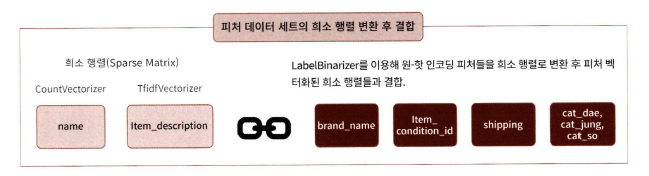

In [15]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [16]:
# 인코딩 데이터 세트 타입과 shape 확인
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


* 인코딩 변환된 데이터 세트 : csr_matrix 타입

피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트 결합

In [17]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


0

* csr_matrix 타입
* 총 161569개의 피처

#### 릿지 회귀 모델 구축 및 평가

모델 평가 로직 함수화

* 적용 평가 지표 : RMSLE(Root Mean Square Logarithmic Error)
  - RMSE와 유사하나 오류 값에 로그 취해 RMSE 구하는 방식
  - 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 도입

  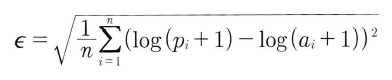

In [18]:
def rmsle(y , y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test , preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

모델 학습/예측 로직 함수화

In [19]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model, matrix_list): # model : 회귀 estimator 객체, matrix_list : 최종 데이터 세트로 결합할 희소 행렬 리스트 
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], 
                                                        test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train 
    gc.collect()
    
    return preds, y_test

Ridge 이용해 Mercari Price의 회귀 예측 수행

In [20]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

# Mercari 상품 가격 예측에 텍스트 형태의 속성(item_description)이 미치는 영향 확인
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010544
Item Description을 포함한 rmsle 값: 0.4712195143433641


* Item Description을 포함했을 때 rmsle 값이 많이 감소

  -> Item Description 중요

#### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

LightGBM 회귀 수행

In [21]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값: 0.45719580244261243


* Ridge보다 예측 성능이 더 나아짐

LightGBM 예측 결괏값과 Ridge 예측 결괏값을 앙상블해 최종 예측 결괏값 도출

In [22]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.4507259214329315


* 앙상블 방식으로 예측 성능 더 개선